In [11]:
import os
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from utils.notebook import display_scrollable_dataframe,plot_sailency
from data_loaders import CUB_extnded_dataset
from models import get_inception_transform
from IPython.display import display

from sailency import get_saliency_maps,saliency_score_part

# Data analysis 
On the use of Majority voting on the concetps. First the data is loaded. 

In [12]:
# Settings for the experiment your running
data_set = 'train' # majority voting is only done  


# You can find the settings in the .hydra folders config.yaml 
data_config_MV = {'CUB_dir':r'data/CUB_200_2011 2/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':True,
                'min_class_count':10,
                'return_visibility':True}

# make copy of the config dict
data_config_noMV = data_config_MV.copy()
data_config_noMV['use_majority_voting'] = False


Load the two datasets, one that uses majority voting and one that uses the original data.

In [13]:
transformer = get_inception_transform(mode='val',methode="center")

data_MV = CUB_extnded_dataset(mode=data_set,config_dict=data_config_MV,transform=transformer, andreas = True, reduce=False)
data_noMV = CUB_extnded_dataset(mode=data_set,config_dict=data_config_noMV,transform=transformer, andreas = True, reduce=False)


n_data = len(data_MV)
n_concepts = data_noMV.n_concepts
n_classes = data_noMV.n_classes

print(f"Number of data points: {n_data}")
print(f"Number of concepts: {n_concepts}")


Number of data points: 4796
Number of concepts: 312


Check out average concepts for each class

100%|██████████| 4796/4796 [00:00<00:00, 11120.20it/s]


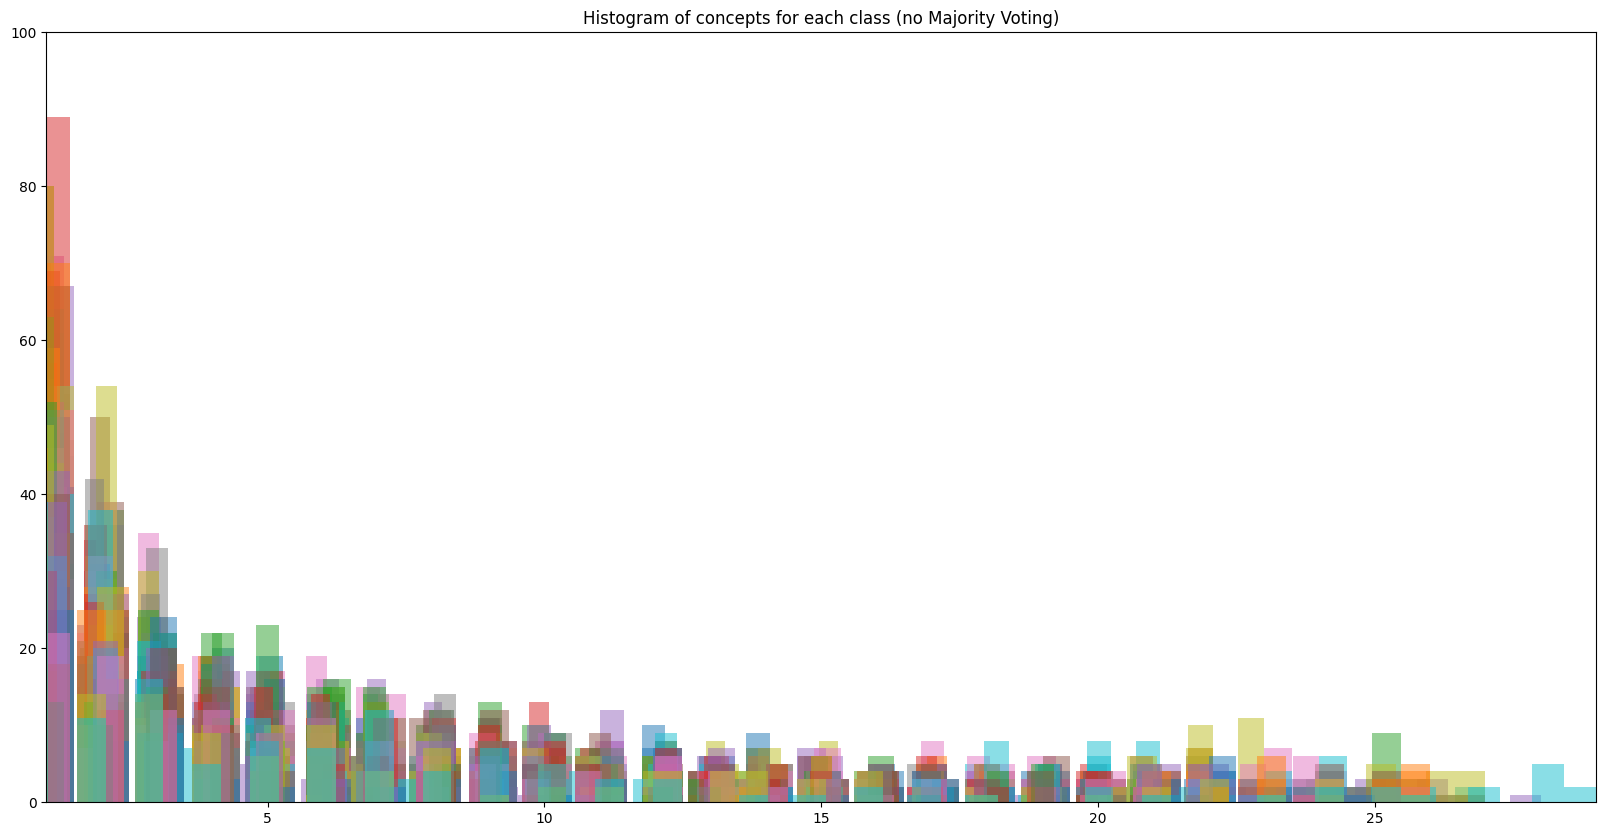

In [29]:
cnt_class_concepts_noMV = np.zeros((n_classes,n_concepts))

for item in tqdm(data_noMV):
    # unpack
    X, C, Y_one_hot, coordinates = item
    concepts = C[0].numpy()
    label = Y_one_hot.argmax().item()

    # Add the array of concepts to the avg_class_concepts
    cnt_class_concepts_noMV[label] += concepts

# hist plot of the concepts for each class
plt.figure(figsize=(20,10))
for i in range(n_classes):

    plt.hist(cnt_class_concepts_noMV[i], bins=50, alpha=0.5, label=f'class {i}')
   
#plt.legend()
plt.title('Histogram of concepts for each class (no Majority Voting)')
plt.xlim(1,cnt_class_concepts_noMV.max())
plt.ylim(0,100)
plt.show()



What class has the most different concepts?

Top 5 classes with most concepts: ['068.Ruby_throated_Hummingbird' '015.Lazuli_Bunting' '066.Western_Gull'
 '067.Anna_Hummingbird' '162.Canada_Warbler']

Concepts for class 158: ['has_bill_shape::curved_(up_or_down)' 'has_bill_shape::dagger'
 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::curved_(up_or_down)' 'has_bill_shape::dagger'
 'has_bill_shape::curved_(up_or_down)' 'has_bill_shape::dagger'
 'has_bill_shape::dagger' 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::curved_(up_or_down)' 'has_bill_shape::dagger'
 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::curved_(up_or_down)' 'has_bill_shape::dagger'
 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::curved_(up_or_down)' 'has_bill_shape::dagger'
 'has_bill_shape::dagger' 'has_bill_shape::curved_(up_or_down)'
 'has_bill_shape::dagger' 'has_bill_s

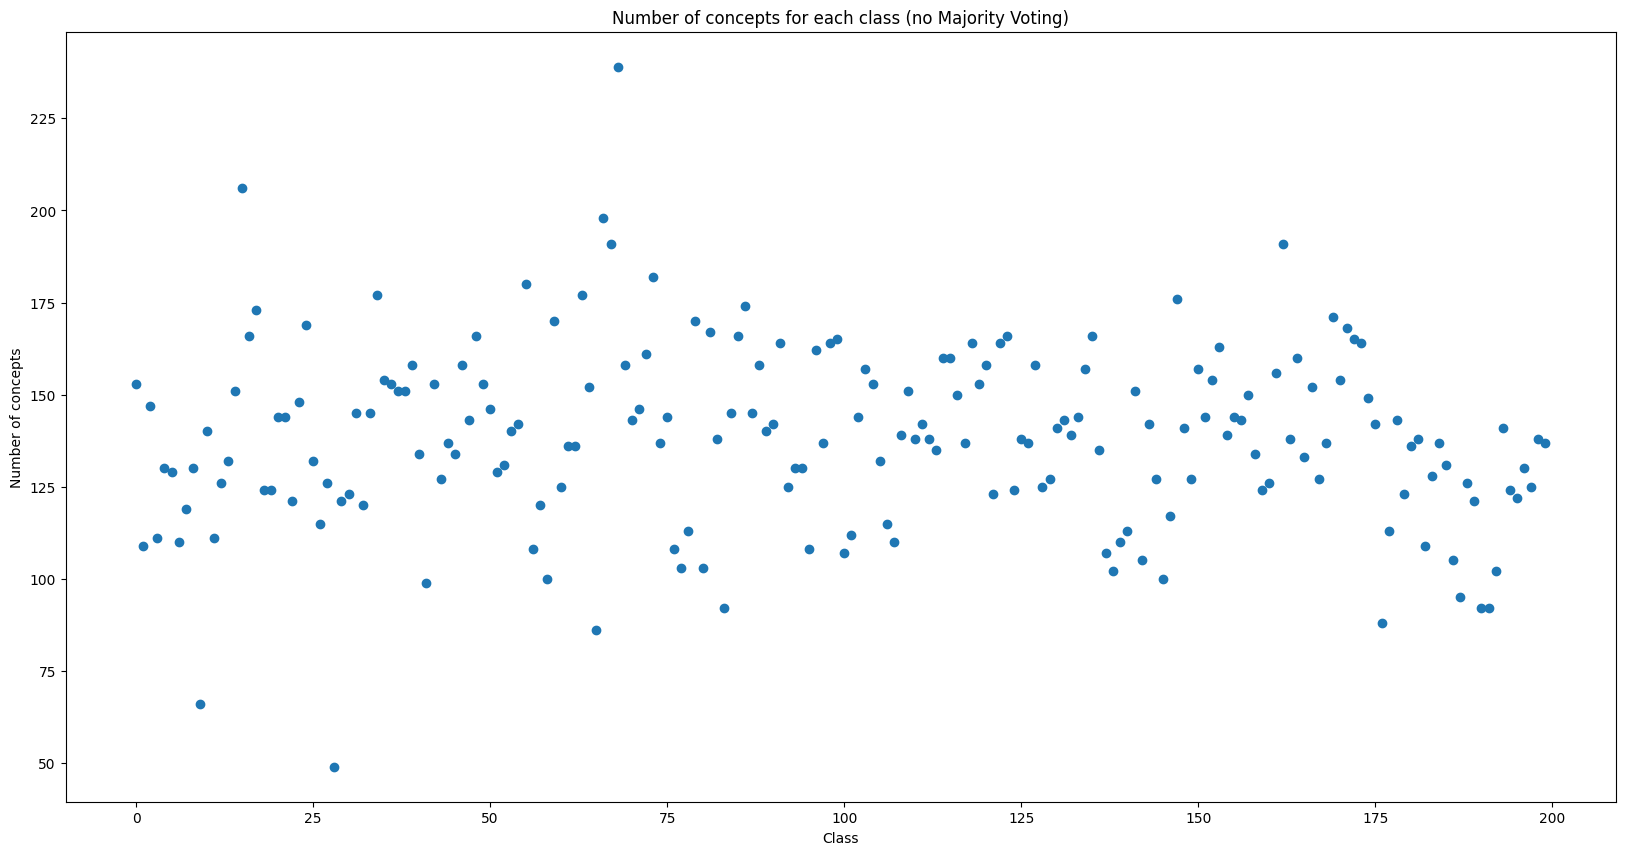

In [60]:
bin_class_concept_noMV = cnt_class_concepts_noMV > 0 

plt.figure(figsize=(20,10))
plt.plot(bin_class_concept_noMV.sum(axis=1), 'o')
plt.ylabel('Number of concepts')
plt.xlabel('Class')
plt.title('Number of concepts for each class (no Majority Voting)')

# load class names
name_dir = 'data/CUB_200_2011 2/CUB_200_2011/classes.txt'
class_names = pd.read_csv(name_dir, sep=' ', header=None, index_col=0)

# 5 classes with the most concepts
n = 5
top_classes = bin_class_concept_noMV.sum(axis=1).argsort()[::-1][:n]
top_classes = class_names.loc[top_classes].values.flatten()
print(f"Top {n} classes with most concepts: {top_classes}\n")


# concept names
concept_names = data_noMV.consept_labels_names

# the conceepts for the class with the most concepts
class_id = cnt_class_concepts_noMV.sum(axis=1).argmax()
concepts = bin_class_concept_noMV[class_id]
concepts = concepts.astype(int)
concept_names = concept_names[concepts]
print(f"Concepts for class {class_id}: {concept_names}")




Get all the concepts for MV

100%|██████████| 4796/4796 [00:00<00:00, 9906.47it/s] 


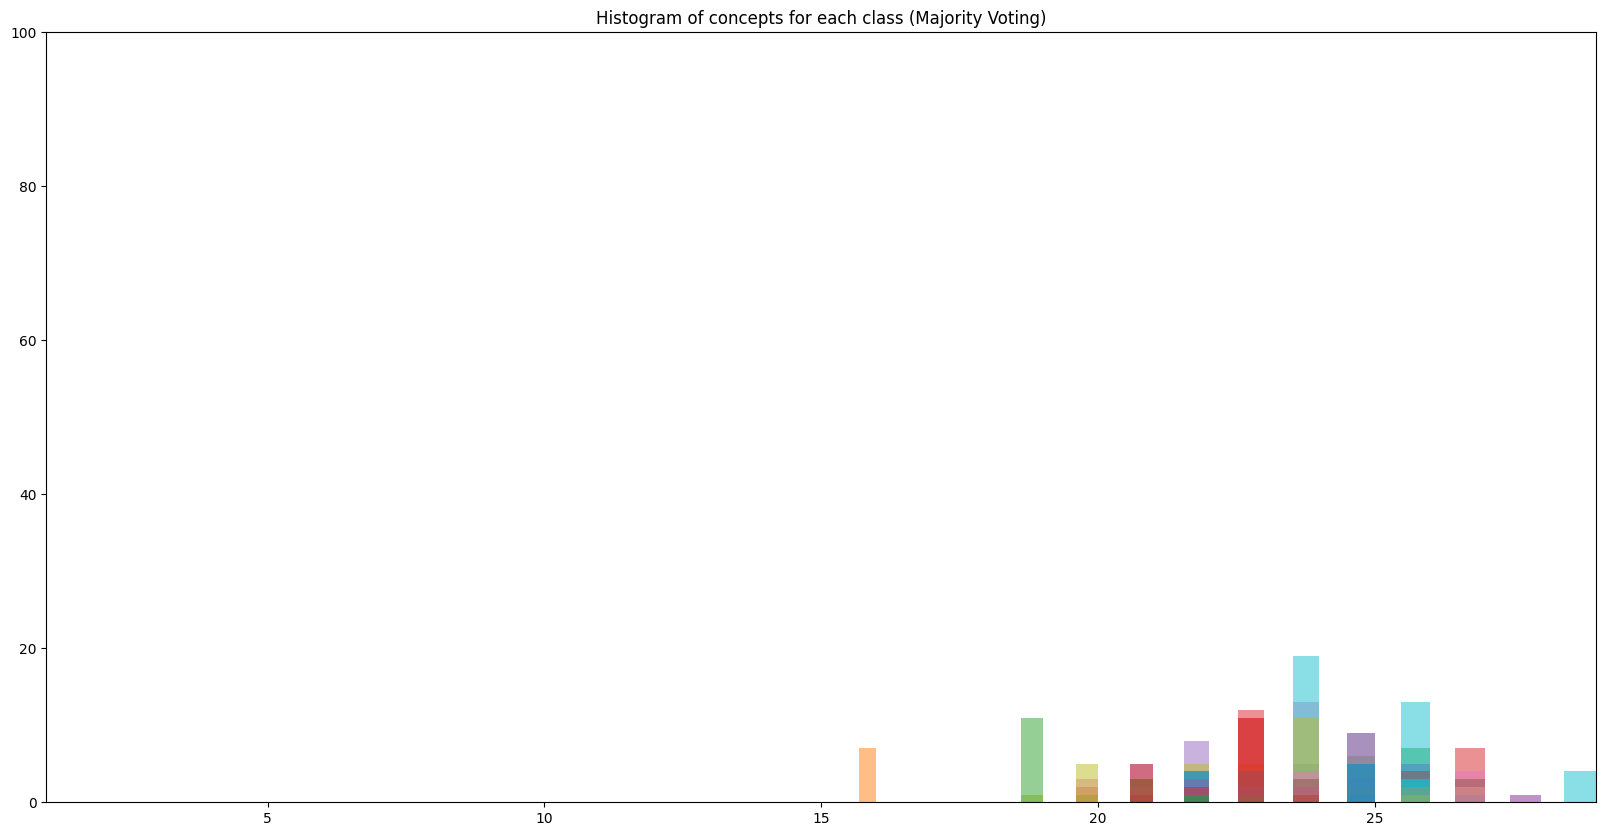

In [30]:
cnt_class_concepts_MV = np.zeros((n_classes,n_concepts))

for item in tqdm(data_MV):
    # unpack
    X, C, Y_one_hot, coordinates = item
   
    concepts = C.numpy()
    label = Y_one_hot.argmax().item()

    # Add the array of concepts to the avg_class_concepts
    cnt_class_concepts_MV[label] += concepts

# hist plot of the concepts for each class
plt.figure(figsize=(20,10))
for i in range(n_classes):
    plt.hist(cnt_class_concepts_MV[i], bins=50, alpha=0.5, label=f'class {i}')
#plt.legend()
plt.title('Histogram of concepts for each class (Majority Voting)')
plt.xlim(1,cnt_class_concepts_MV.max())
plt.ylim(0,100)
plt.show()


What class is affected the most by MV?

Most affected class: 158: 158.Bay_breasted_Warbler


Text(0.5, 1.0, 'Difference in concepts for each class')

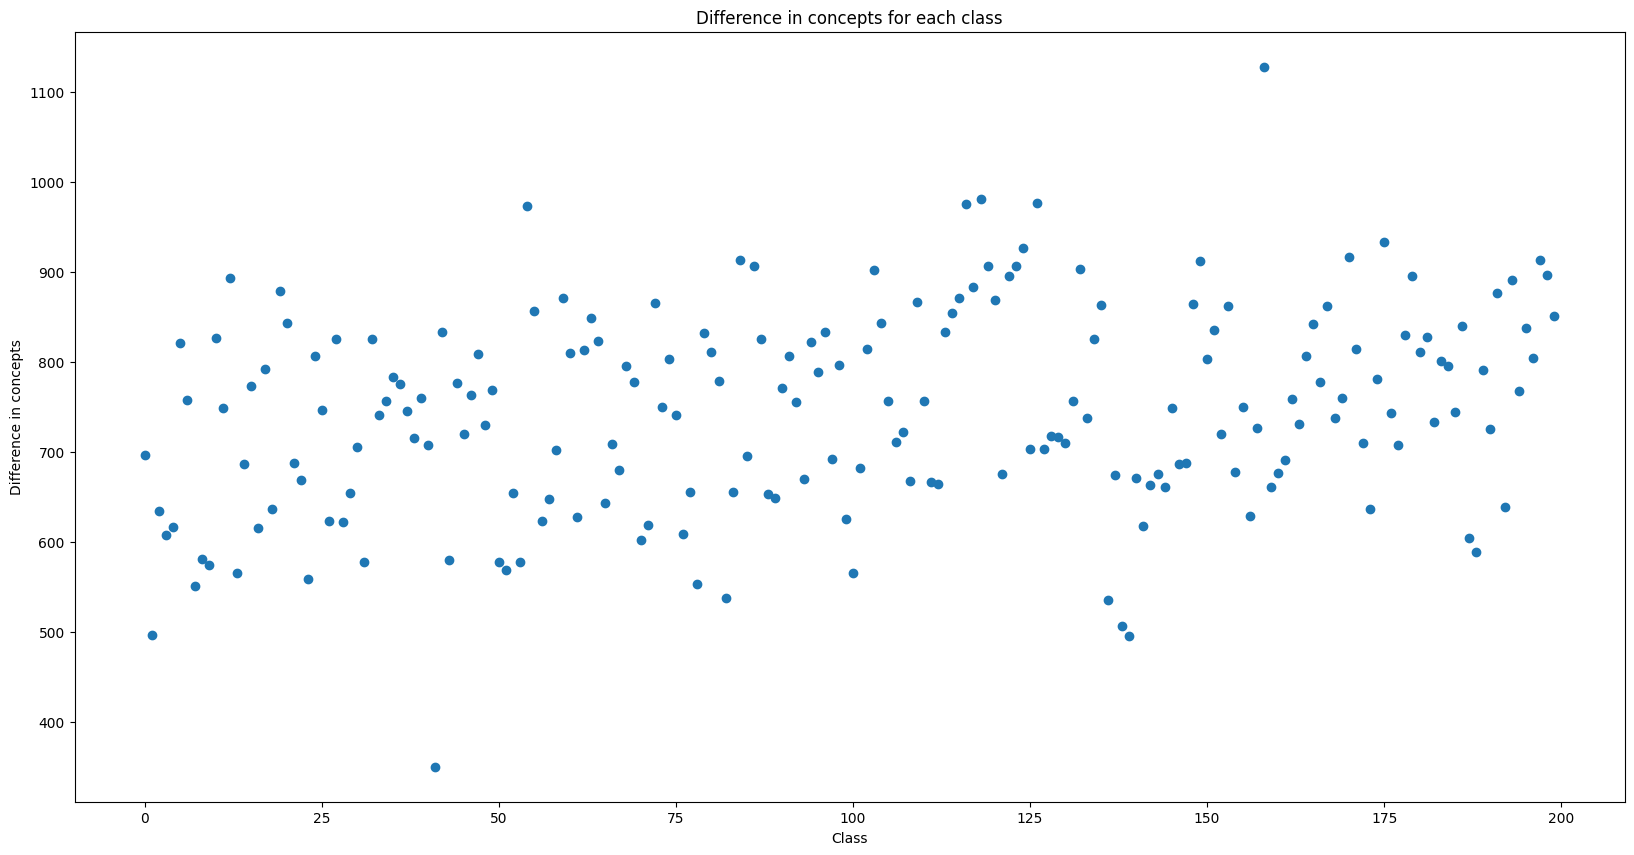

In [72]:
# find the difference between the concepts
diff = cnt_class_concepts_MV - cnt_class_concepts_noMV

# most affected class
most_affected_class = np.abs(diff).sum(axis=1).argmax()
print(f"Most affected class: {most_affected_class}: {class_names.loc[most_affected_class].values[0]}")

plt.figure(figsize=(20,10))
plt.plot(np.abs(diff).sum(axis=1), 'o')
plt.ylabel('Difference in concepts')
plt.xlabel('Class')
plt.title('Difference in concepts for each class')


examples of 158.Bay_breasted_Warbler. Image id: 9232 to 9291

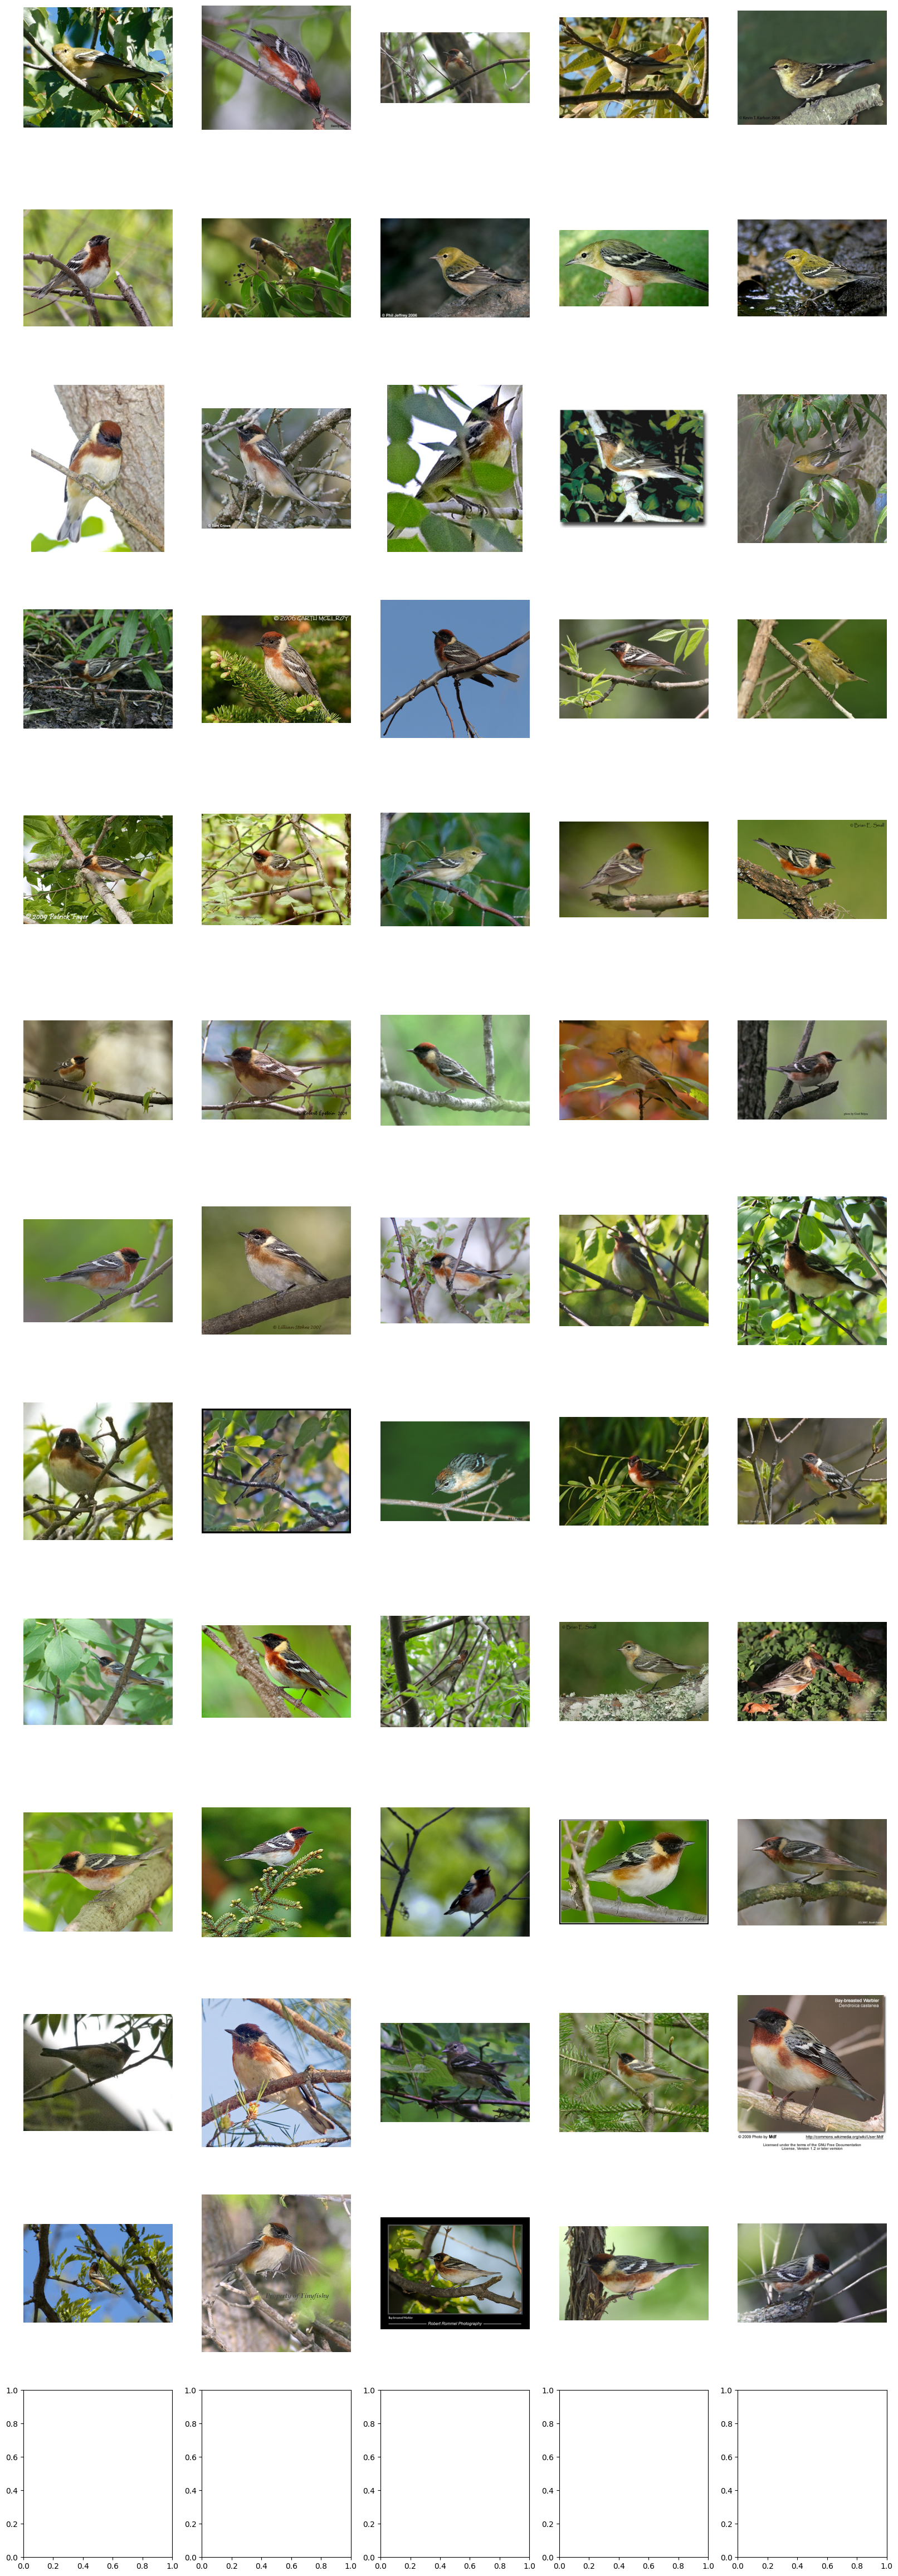

In [89]:
im_dir = 'data/CUB_200_2011 2/CUB_200_2011/images'

# load images for specific class
id = most_affected_class
folder = os.path.join(im_dir, class_names.loc[id].values[0])

# get all images in the folder
images = os.listdir(folder)

# load all images
images = [torchvision.io.read_image(os.path.join(folder, im)) for im in images]

# plot the images
n = 5
n_rows = len(images) // n + 1
fig, axs = plt.subplots(n_rows, n, figsize=(20, 60))
for i, im in enumerate(images):
    ax = axs[i // n, i % n]
    ax.imshow(im.permute(1, 2, 0))
    ax.axis('off')
plt.show()

